## Neural networks for segmentation

In [6]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip

zsh:1: no matches found: https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [1]:
! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [14]:
!pip install torch torchvision

  Using cached torch-1.11.0-cp39-cp39-manylinux1_x86_64.whl (750.6 MB)
  Using cached torchvision-0.12.0-cp39-cp39-manylinux1_x86_64.whl (21.0 MB)


In [15]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
import skimage.io
import skimage
import os

import torch
import numpy as np
import torchvision
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data.dataset import Dataset
import random
import torchvision.transforms.functional as TF
from PIL import Image

import itertools
%matplotlib inline

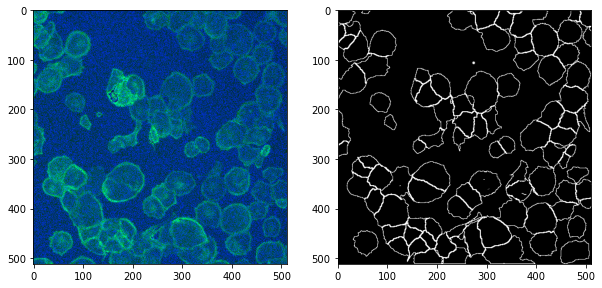

In [16]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [17]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [18]:
train_images_path = ['./BBBC018_v1_images-fixed/train/' + fname for fname in os.listdir('./BBBC018_v1_images-fixed/train')]
train_masks_path = ['./BBBC018_v1_outlines/train/' + fname for fname in os.listdir('./BBBC018_v1_images-fixed/train')]

val_images_path = ['./BBBC018_v1_images-fixed/val/' + fname for fname in os.listdir('./BBBC018_v1_images-fixed/val')]
val_masks_path = ['./BBBC018_v1_outlines/val/' + fname for fname in os.listdir('./BBBC018_v1_images-fixed/val')]

class SegmentationDataset(Dataset):
    def __init__(self, image_paths=None, target_paths=None, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.train = train

    def transform(self, image, mask):
        # Resize
        if self.train:
            # Random vertical flipping
            if random.random() > 0.35:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
#                 mask = YOUR CODE

            if random.random() > 0.3:
                image = TF.rotate(image, 30)
                mask = TF.rotate(mask, 30)
           
            # Random rotate using TF.rotate(image, angle)
            
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = (TF.to_tensor(mask) > 0.01).type(torch.FloatTensor)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.target_paths:
            mask = Image.open(self.target_paths[index][:-14] + '-cells.png')
        else:
            mask = Image.open(self.image_paths[index])
            x, y = self.transform(image, mask)
            return x, self.image_paths[index]
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [19]:
train_dataset = SegmentationDataset(image_paths=train_images_path, target_paths=train_masks_path, train=False)
val_dataset = SegmentationDataset(image_paths=val_images_path, target_paths=val_masks_path, train=False)

In [20]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.1922, 0.1922, 0.1922,  ..., 0.0000, 0.0000, 0.0000],
          [0.2235, 0.1922, 0.1922,  ..., 0.3529, 0.3216, 0.4196],
          [0.1922, 0.1922, 0.1922,  ..., 0.3529, 0.3529, 0.3882],
          ...,
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1608, 0.1608],
          [0.1922, 0.1922, 0.2235,  ..., 0.1922, 0.1922, 0.1608],
          [0.1922, 0.1922, 0.1608,  ..., 0.1922, 0.1608, 0.1922]],
 
         [[0.1608, 1.0000, 0.6784,  ..., 0.0000, 0.0000, 0.0000],
          [0.0627, 0.7098, 0.3529,  ..., 0.0314, 1.0000, 0.1608],
          [0.9059, 0.5176, 0.4510,  ...,

In [21]:
batch_size = 32
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
class Net(nn.Module):
    def __init__(self, filters):
        super(Net, self).__init__()
        self.filters = filters

        encoder_layers = []
        in_filters = 3
        for i, ifilters in enumerate(filters):            
            encoder_layers.append(nn.ModuleList([
                nn.MaxPool2d(2),

                nn.Conv2d(in_filters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),

                nn.Conv2d(ifilters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),
            ]))
            in_filters = ifilters

        self.encoder_list = encoder_layers
        [self.add_module('encoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.encoder_list)))]

        decoder_layers = []
        for i in range(len(filters) - 1):
            print(i)
            print('filters ', -i -2,  '', filters[-i-2])
            decoder_layers.append(([
                nn.ConvTranspose2d(filters[-i - 1], filters[-i - 2], kernel_size=2, stride=2),
                nn.Conv2d(filters[-i - 1], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU(),

                nn.Conv2d(filters[-i - 2], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU()
                ]))
        decoder_layers.append(
            ([nn.ConvTranspose2d(filters[0], filters[0], kernel_size=2, stride=2)]))

        self.decoder_list = decoder_layers
        self.encoder_outputs = []
        [self.add_module('decoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.decoder_list)))]

        self.head_list = [nn.Conv2d(filters[0], 1, kernel_size=1), nn.Sigmoid()]
        [self.add_module('my_head' + str(i), layer) for i, layer in enumerate(self.head_list)]

    def encoder(self, x):
        output = x
        for i, block in enumerate(self.encoder_list):
            for j, layer in enumerate(block):
                output = layer(output)
            self.encoder_outputs.append(output)
        return output

    def decoder(self, x):
        output = x
        for i, block in enumerate(self.decoder_list[:-1]):
            upsampled_x = block[0](output)
            encoder_tensor = self.encoder_outputs[-i - 2]
            output = torch.cat([encoder_tensor, upsampled_x], 1)
            for j, layer in enumerate(block[1:]):
                output = layer(output)
        output = self.decoder_list[-1][0](output)
        return output

    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        output = self.head_list[0](decoder_output)
        self.encoder_outputs = []
        return self.head_list[1](output)


In [23]:
model = Net([10, 20, 40])

0
filters  -2  20
1
filters  -3  10


In [24]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []
compute_loss = nn.BCELoss()

import time
num_epochs = 274

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)
        logits = model(X_batch)

        y_batch = y_batch.view(y_batch.size(0), -1)
        y_predicted = (logits.view(X_batch.size(0), -1))

        loss = compute_loss(y_predicted, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.data.numpy())
    print (epoch)

    model.train(False)
    for X_batch, y_batch in val_batch_gen:

        logits = model(torch.FloatTensor(X_batch)).data.numpy()
        y_pred = (logits > 0.3).astype(np.float32)

        val_accuracy.append(calc_iou(y_pred, y_batch.numpy()))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

/tmp/ipykernel_1212/38668050.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
/tmp/ipykernel_1212/38668050.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32)


0
Epoch 1 of 274 took 7.926s
  training loss (in-iteration): 	0.711629
  validation accuracy: 			5.29 %
1
Epoch 2 of 274 took 6.607s
  training loss (in-iteration): 	0.697327
  validation accuracy: 			5.29 %
2
Epoch 3 of 274 took 6.631s
  training loss (in-iteration): 	0.685240
  validation accuracy: 			5.29 %
3
Epoch 4 of 274 took 6.711s
  training loss (in-iteration): 	0.673409
  validation accuracy: 			5.29 %
4
Epoch 5 of 274 took 6.757s
  training loss (in-iteration): 	0.661634
  validation accuracy: 			5.29 %
5
Epoch 6 of 274 took 6.615s
  training loss (in-iteration): 	0.649250
  validation accuracy: 			5.29 %
6
Epoch 7 of 274 took 6.577s
  training loss (in-iteration): 	0.636927
  validation accuracy: 			5.29 %
7
Epoch 8 of 274 took 6.794s
  training loss (in-iteration): 	0.624010
  validation accuracy: 			5.29 %
8
Epoch 9 of 274 took 6.703s
  training loss (in-iteration): 	0.611129
  validation accuracy: 			5.29 %
9
Epoch 10 of 274 took 6.712s
  training loss (in-iteration): 	0

In [25]:
TRESHOLD = 0.3

/tmp/ipykernel_1212/3582166351.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  ax[0].imshow(X_batch[i, ...].T)


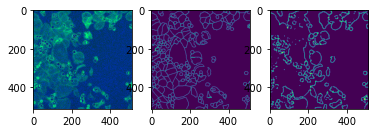

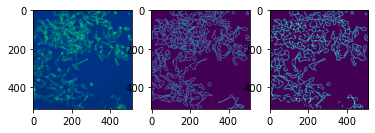

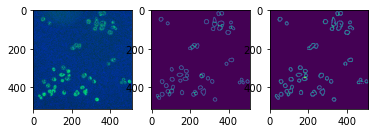

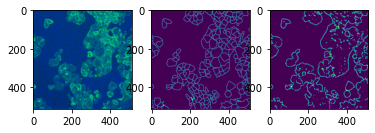

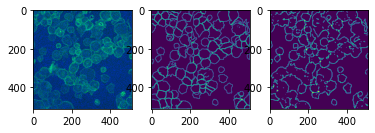

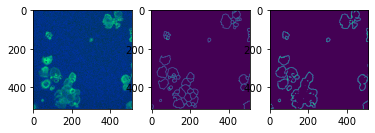

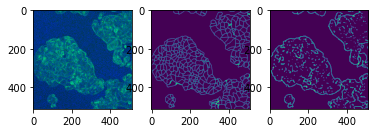

In [26]:
for X_batch, y_batch in val_batch_gen:
    logits = model(torch.FloatTensor(X_batch)).data.numpy()
    y_pred = (logits > TRESHOLD).astype(np.float32)
    for i in range(len(X_batch)):
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(X_batch[i, ...].T)
        ax[1].imshow(y_batch[i,...].T[..., 0])
        ax[2].imshow(y_pred[i, ...].T[..., 0])
        plt.show()
